<a href="https://colab.research.google.com/github/Lenferd/pcam_train/blob/lab5-optimize-train-param/lab-5-learning-transfer/pcam_lab_5_densnet_from_scratch.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Keras imports

In [0]:
import os
import tensorflow as tf
import numpy as np

%pip install keras-metrics
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'

# Load dataset

In [0]:
from google.colab import drive
drive.mount('/content/drive')
os.chdir('/content/drive/My Drive/DL_PCAM')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [0]:
train_x_name = 'camelyonpatch_level_2_split_train_x.h5'
train_y_name = 'camelyonpatch_level_2_split_train_y.h5'

test_x_name = 'camelyonpatch_level_2_split_test_x.h5'
test_y_name = 'camelyonpatch_level_2_split_test_y.h5'

valid_x_name = 'camelyonpatch_level_2_split_valid_x.h5'
valid_y_name = 'camelyonpatch_level_2_split_valid_y.h5'

meta_train_name = 'camelyonpatch_level_2_split_train_meta.csv'
meta_valid_name = 'camelyonpatch_level_2_split_valid_meta.csv'
meta_test_name  = 'camelyonpatch_level_2_split_test_meta.csv'

In [0]:
from keras.utils import HDF5Matrix, normalize

x_train = HDF5Matrix(train_x_name, 'x', 
                     normalizer=lambda x: np.true_divide(x, 255.))
y_train = HDF5Matrix(train_y_name, 'y')

x_valid = HDF5Matrix(valid_x_name, 'x', 
                     normalizer=lambda x: np.true_divide(x, 255.))
y_valid = HDF5Matrix(valid_y_name, 'y')

x_test  = HDF5Matrix(test_x_name, 'x', 
                     normalizer=lambda x: np.true_divide(x, 255.))
y_test  = HDF5Matrix(test_y_name, 'y')

Using TensorFlow backend.


# Reshape labels

In [0]:
# Input image dimensions.
input_shape = x_train.shape[1:]

y_train = np.array(y_train)
y_train = y_train.reshape((y_train.shape[0], 1))

y_valid = np.array(y_valid)
y_valid = y_valid.reshape((y_valid.shape[0], 1))

y_test = np.array(y_test)
y_test = y_test.reshape((y_test.shape[0], 1))

print('input share:', input_shape)
print('x_train shape:', x_train.shape)

print(x_train.shape[0], 'train samples')
print(x_test.shape[0], 'test samples')
print('y_train shape:', y_train.shape)

input share: (96, 96, 3)
x_train shape: (262144, 96, 96, 3)
262144 train samples
32768 test samples
y_train shape: (262144, 1)


In [0]:
y_train = y_train.reshape((y_train.shape[0], 1))
print("1 in train : {}".format(np.count_nonzero(y_train == 1)))
print("0 in train : {}".format(np.count_nonzero(y_train == 0)))

y_valid = y_valid.reshape((y_valid.shape[0], 1))
print("1 in valid : {}".format(np.count_nonzero(y_valid == 1)))
print("0 in valid : {}".format(np.count_nonzero(y_valid == 0)))

1 in train : 131072
0 in train : 131072
1 in valid : 16369
0 in valid : 16399


# Prepare Densnet121 model

In [0]:
from keras.applications.densenet import DenseNet121
from keras.models import Sequential
from keras import layers

def denseNet_empty(input_shape, num_classes=1):
  densenet_model = DenseNet121(weights=None, include_top=False, input_shape=input_shape)
  model = Sequential()
  model.add(densenet_model)
  model.add(layers.GlobalAveragePooling2D())
  model.add(layers.Dense(1, activation='sigmoid', name='fc1', kernel_initializer = 'he_normal'))
  return model

In [0]:
model = denseNet_empty(input_shape)

## Densnet info

### Summary

In [0]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
densenet121 (Model)          (None, 3, 3, 1024)        7037504   
_________________________________________________________________
global_average_pooling2d_1 ( (None, 1024)              0         
_________________________________________________________________
fc1 (Dense)                  (None, 1)                 1025      
Total params: 7,038,529
Trainable params: 6,954,881
Non-trainable params: 83,648
_________________________________________________________________


### Plot

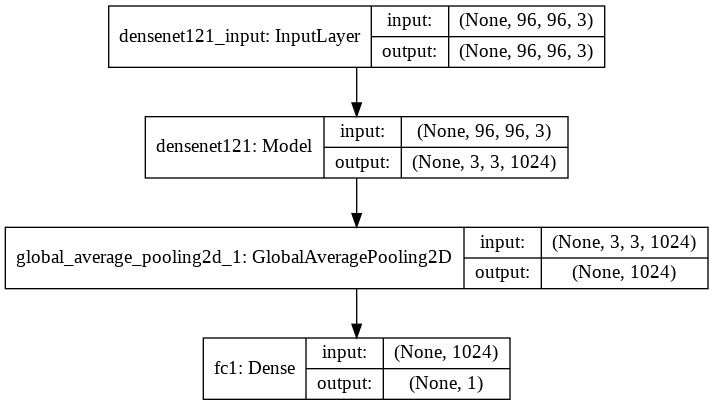

In [0]:
from keras.utils.vis_utils import plot_model
plot_model(model, show_shapes=True, show_layer_names=True)

#Compile & run model

In [0]:
# PARAMS
LEARN_RATE = 1e-4   # 1e-3
BATCH_SIZE = 256
EPOCHS = 10

In [0]:
from keras.optimizers import Adam
import keras_metrics as k_metrics

model.compile(loss='binary_crossentropy',
              optimizer=Adam(lr=LEARN_RATE),
              metrics = ['binary_accuracy', 
                          k_metrics.binary_precision(), 
                          k_metrics.binary_recall(),
                          k_metrics.binary_f1_score()
                        ])



Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where



In [0]:
history = model.fit(x_train, y_train,
          batch_size=BATCH_SIZE,
          epochs=EPOCHS,
          validation_data=(x_test, y_test),
          shuffle="batch")


Train on 262144 samples, validate on 32768 samples
Epoch 1/10
262144/262144 [==============================] - 483s 2ms/step - loss: 0.3301 - binary_accuracy: 0.8593 - precision: 0.8620 - recall: 0.8555 - f1_score: 0.8588 - val_loss: 0.8142 - val_binary_accuracy: 0.6530 - val_precision: 0.9494 - val_recall: 0.3230 - val_f1_score: 0.4820
Epoch 2/10
262144/262144 [==============================] - 404s 2ms/step - loss: 0.2010 - binary_accuracy: 0.9208 - precision: 0.9229 - recall: 0.9184 - f1_score: 0.9207 - val_loss: 0.4938 - val_binary_accuracy: 0.7829 - val_precision: 0.8805 - val_recall: 0.6544 - val_f1_score: 0.7508
Epoch 3/10
262144/262144 [==============================] - 402s 2ms/step - loss: 0.1567 - binary_accuracy: 0.9397 - precision: 0.9420 - recall: 0.9371 - f1_score: 0.9396 - val_loss: 0.7172 - val_binary_accuracy: 0.7226 - val_precision: 0.9094 - val_recall: 0.4942 - val_f1_score: 0.6404
Epoch 4/10
262144/262144 [==============================] - 402s 2ms/step - loss: 0.

# Metrics

In [0]:
from matplotlib import pyplot

# Prepare metrics functions
def plot_metrics(code_metrics, name_metrics):
    pyplot.plot(history.history[code_metrics])
    pyplot.plot(history.history['val_' + code_metrics])
    pyplot.title('Model ' + name_metrics)
    pyplot.ylabel(name_metrics)
    pyplot.xlabel('Epoch')
    pyplot.legend(['Train', 'Test'], loc='upper left')
    pyplot.show()

def show_metrics(list_metrics, name_stage, name_model):
    name_metrics = ['accuracy', 'precision', 'recall', 'f1-score']
    for i in range(4):
        print(name_model + ' ' + name_stage + ' ' + 
              name_metrics[i] + ' : ' + str(list_metrics[i + 1] * 100))

In [0]:
prediction = model.predict(x_train)
print(">=0.5 (1): {}".format(np.count_nonzero(prediction >= 0.5)))
print("<0.5 (0): {}".format(np.count_nonzero(prediction < 0.5)))

print("1 in train : {}".format(np.count_nonzero(y_train == 1)))
print("0 in train : {}".format(np.count_nonzero(y_train == 0)))

print(prediction)

>=0.5 (1): 99320
<0.5 (0): 162824
1 in train : 131072
0 in train : 131072
[[5.2710474e-03]
 [9.9921131e-01]
 [9.9196839e-01]
 ...
 [9.9755418e-01]
 [1.2993813e-04]
 [9.7954571e-02]]


In [0]:
prediction = model.predict(x_test)
print(">=0.5 (1): {}".format(np.count_nonzero(prediction >= 0.5)))
print("<0.5 (0): {}".format(np.count_nonzero(prediction < 0.5)))

print("1 in test : {}".format(np.count_nonzero(y_test == 1)))
print("0 in test : {}".format(np.count_nonzero(y_test == 0)))

print(prediction)

>=0.5 (1): 9146
<0.5 (0): 23622
1 in test : 16377
0 in test : 16391
[[3.5402179e-04]
 [3.0945444e-01]
 [2.6990175e-03]
 ...
 [8.3459121e-01]
 [8.8619995e-01]
 [3.8042068e-03]]


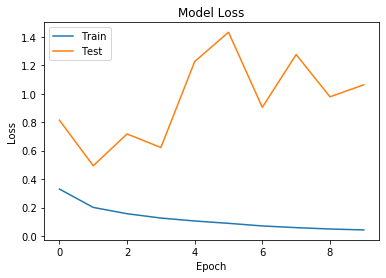

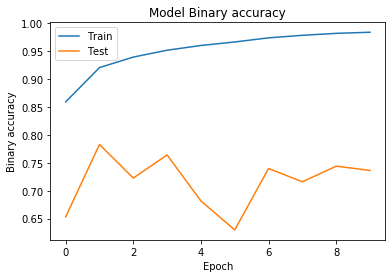

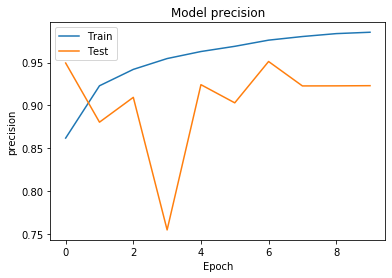

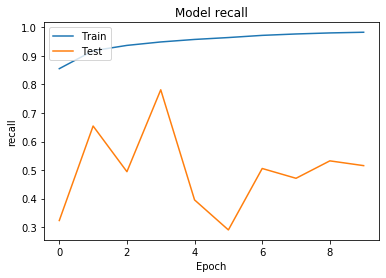

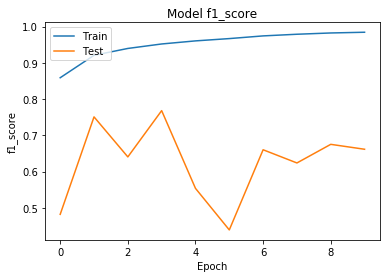

In [0]:
plot_metrics('loss', 'Loss')
plot_metrics('binary_accuracy',  'Binary accuracy')
plot_metrics('precision', 'precision')
plot_metrics('recall', 'recall')
plot_metrics('f1_score',  'f1_score')

In [0]:
name_model = "densNet121-from-scratch"
show_metrics(model.evaluate(x_train, y_train), 'train', name_model)
show_metrics(model.evaluate(x_valid, y_valid), 'valid', name_model)
show_metrics(model.evaluate(x_test,  y_test),  'test',  name_model)

262144/262144 [==============================] - 248s 947us/step
densNet121-from-scratch train accuracy : 85.0341796875
densNet121-from-scratch train precision : 96.23439387827604
densNet121-from-scratch train recall : 72.92175292963186
densNet121-from-scratch train f1-score : 82.9716260543046
32768/32768 [==============================] - 32s 987us/step
densNet121-from-scratch valid accuracy : 75.6103515625
densNet121-from-scratch valid precision : 92.70058109804566
densNet121-from-scratch valid recall : 55.550125236388595
densNet121-from-scratch valid f1-score : 69.47054310167069
32768/32768 [==============================] - 31s 946us/step
densNet121-from-scratch test accuracy : 73.6358642578125
densNet121-from-scratch test precision : 92.30264596444016
densNet121-from-scratch test recall : 51.54790254593913
densNet121-from-scratch test f1-score : 66.15209350840271
